# Data Mining Project - Part 2 (SIS 2): Modeling & Evaluation

## Goal
This notebook covers the second part of the project (SIS 2), focusing on applying data mining techniques, evaluating models, and interpreting results.

## Requirements:
1. **Data Mining Techniques**: Apply 4-5 algorithms (Classification).
2. **Model Evaluation**: Metrics (Accuracy, Precision, Recall, F1, ROC-AUC), Cross-validation.
3. **Hyperparameter Tuning**: Optimize model performance.
4. **Comparison**: Compare models and select the best one.
5. **Interpretation**: Feature importance, Confusion Matrix, ROC Curve.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Model Selection & Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve

# Settings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Data
We use the processed data with selected features from Part 1.

In [2]:
# Load processed data
print("Loading processed data...")
df = pd.read_csv('../data_processed/train_processed_selected.csv')
print(f"Data shape: {df.shape}")

# Separate features and target
X = df.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = df['TARGET']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Check class balance
print("\nTarget distribution:")
print(y.value_counts(normalize=True))

Loading processed data...
Data shape: (307511, 42)
Features shape: (307511, 40)
Target shape: (307511,)

Target distribution:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


## 2. Train-Test Split
We split the data into training (80%) and testing (20%) sets. Stratified split is used due to class imbalance.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

Training set: (246008, 40)
Testing set: (61503, 40)


## 3. Methodology: Algorithms Selection
We will apply the following 5 algorithms:
1. **Logistic Regression**: A robust baseline for binary classification.
2. **Decision Tree**: Provides interpretability and captures non-linear relationships.
3. **Random Forest**: An ensemble method that reduces overfitting and improves accuracy.
4. **Gradient Boosting (GBM)**: Builds models sequentially to correct errors of previous models.
5. **Gaussian Naive Bayes**: A probabilistic classifier, good for high-dimensional data (fast baseline).

In [4]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced', n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}

print("Models initialized.")

Models initialized.


## 4. Model Training & Evaluation (Baseline)
We will train each model and evaluate using multiple metrics.

In [5]:
results = []

print("Training models...")
for name, model in models.items():
    start_time = time.time()
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else np.zeros(len(y_test))
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    
    elapsed_time = time.time() - start_time
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'ROC AUC': roc,
        'Time (s)': elapsed_time
    })
    
    print(f"{name} done in {elapsed_time:.2f}s")

# Create DataFrame
results_df = pd.DataFrame(results)
results_df.sort_values(by='ROC AUC', ascending=False, inplace=True)
results_df

Training models...
Logistic Regression done in 1.60s
Decision Tree done in 3.17s
Random Forest done in 8.18s
Gradient Boosting done in 43.36s
Naive Bayes done in 0.12s


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,Time (s)
3,Gradient Boosting,0.919337,0.520408,0.010272,0.020146,0.747247,43.364527
0,Logistic Regression,0.684715,0.157632,0.668882,0.255138,0.739590,1.596828
2,Random Forest,0.919191,0.419355,0.002618,0.005204,0.721116,8.178511
4,Naive Bayes,0.121441,0.082796,0.980665,0.152700,0.669928,0.124552
1,Decision Tree,0.860251,0.143838,0.147633,0.145711,0.535232,3.174692


## 5. Hyperparameter Tuning
We will tune the hyperparameters of the **Random Forest** model (or the best performing one) to improve performance. We use `RandomizedSearchCV` for efficiency.

In [6]:
# Define hyperparameter grid for Random Forest
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

print("Starting Hyperparameter Tuning for Random Forest...")
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings that are sampled
    cv=3,       # 3-fold cross-validation
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)

print(f"Best Parameters: {random_search.best_params_}")
print(f"Best ROC AUC Score: {random_search.best_score_:.4f}")

# Get best model
best_rf = random_search.best_estimator_

Starting Hyperparameter Tuning for Random Forest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None}
Best ROC AUC Score: 0.7355


### Impact of Hyperparameters
Let's visualize how changing `max_depth` affects the model performance.

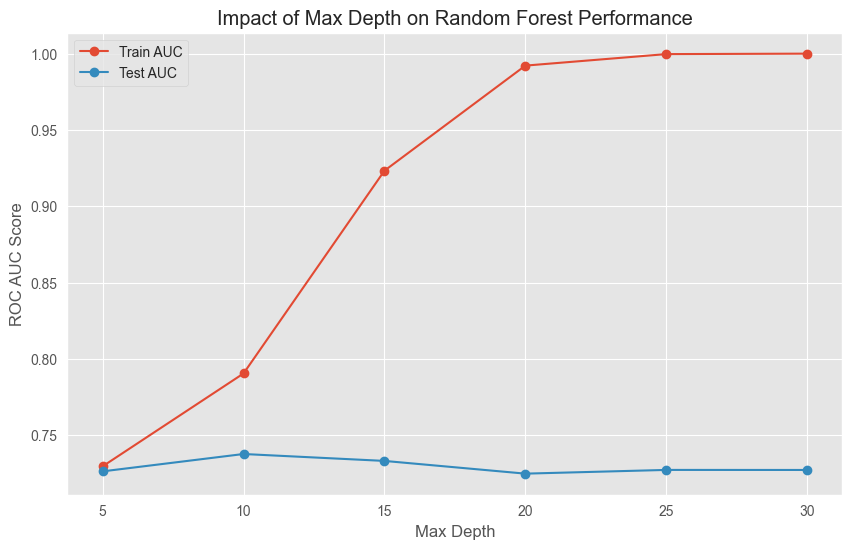

In [7]:
depths = [5, 10, 15, 20, 25, 30]
train_scores = []
test_scores = []

for d in depths:
    clf = RandomForestClassifier(max_depth=d, n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
    clf.fit(X_train, y_train)
    
    train_scores.append(roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
    test_scores.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

plt.figure(figsize=(10, 6))
plt.plot(depths, train_scores, label='Train AUC', marker='o')
plt.plot(depths, test_scores, label='Test AUC', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('ROC AUC Score')
plt.title('Impact of Max Depth on Random Forest Performance')
plt.legend()
plt.show()

## 6. Final Model Evaluation & Comparison
Comparison between Baseline Random Forest and Tuned Random Forest.

In [8]:
# Evaluate Best Model on Test Set
y_pred_best = best_rf.predict(X_test)
y_prob_best = best_rf.predict_proba(X_test)[:, 1]

print("Tuned Random Forest Performance:")
print(classification_report(y_test, y_pred_best))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_best):.4f}")

# Compare with Baseline
baseline_rf = models['Random Forest']
y_prob_baseline = baseline_rf.predict_proba(X_test)[:, 1]

print(f"Baseline RF ROC AUC: {roc_auc_score(y_test, y_prob_baseline):.4f}")

Tuned Random Forest Performance:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     56538
           1       0.42      0.07      0.13      4965

    accuracy                           0.92     61503
   macro avg       0.67      0.53      0.54     61503
weighted avg       0.88      0.92      0.89     61503

ROC AUC: 0.7419
Baseline RF ROC AUC: 0.7211


## 7. Results & Interpretation
### Confusion Matrix

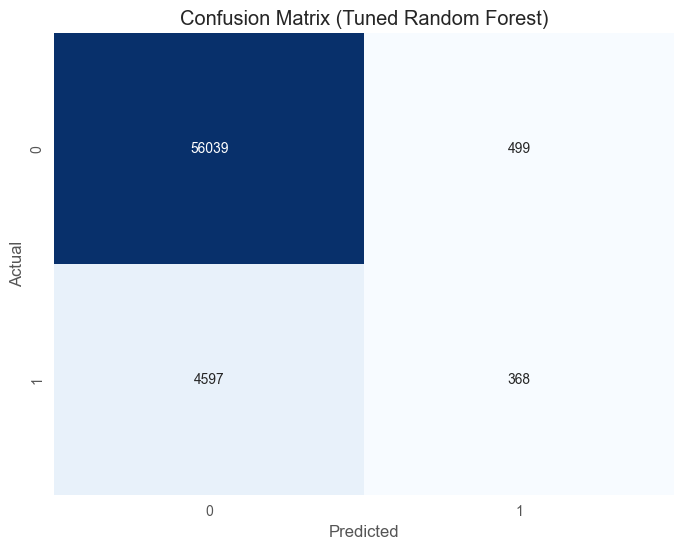

In [9]:
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Tuned Random Forest)')
plt.show()

### ROC Curve Comparison

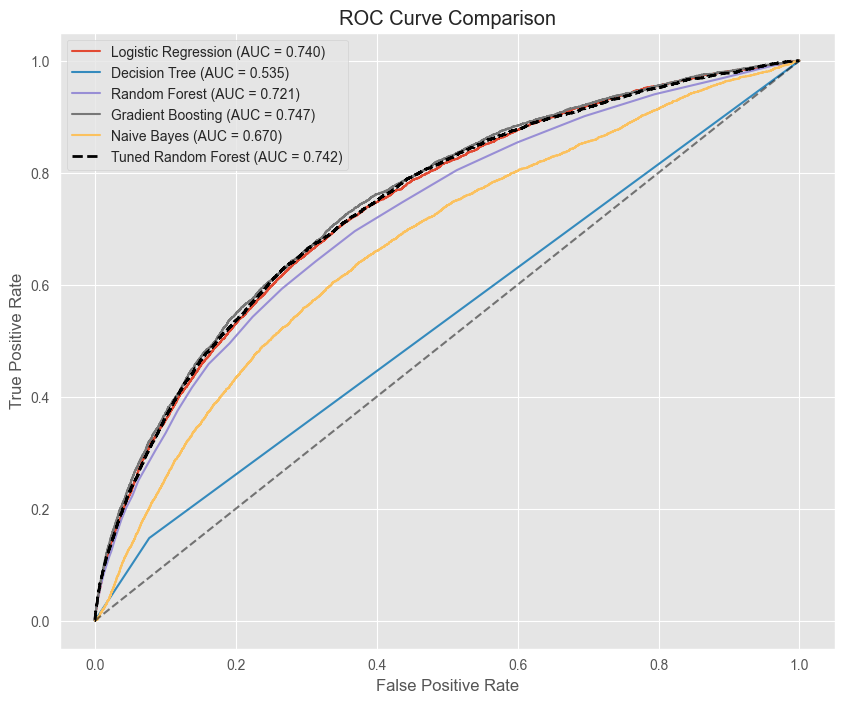

In [10]:
plt.figure(figsize=(10, 8))

# Plot ROC for all models
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

# Plot Tuned RF
fpr_best, tpr_best, _ = roc_curve(y_test, y_prob_best)
auc_best = roc_auc_score(y_test, y_prob_best)
plt.plot(fpr_best, tpr_best, label=f"Tuned Random Forest (AUC = {auc_best:.3f})", linestyle='--', linewidth=2, color='black')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

### Feature Importance
Which features contributed most to the prediction?

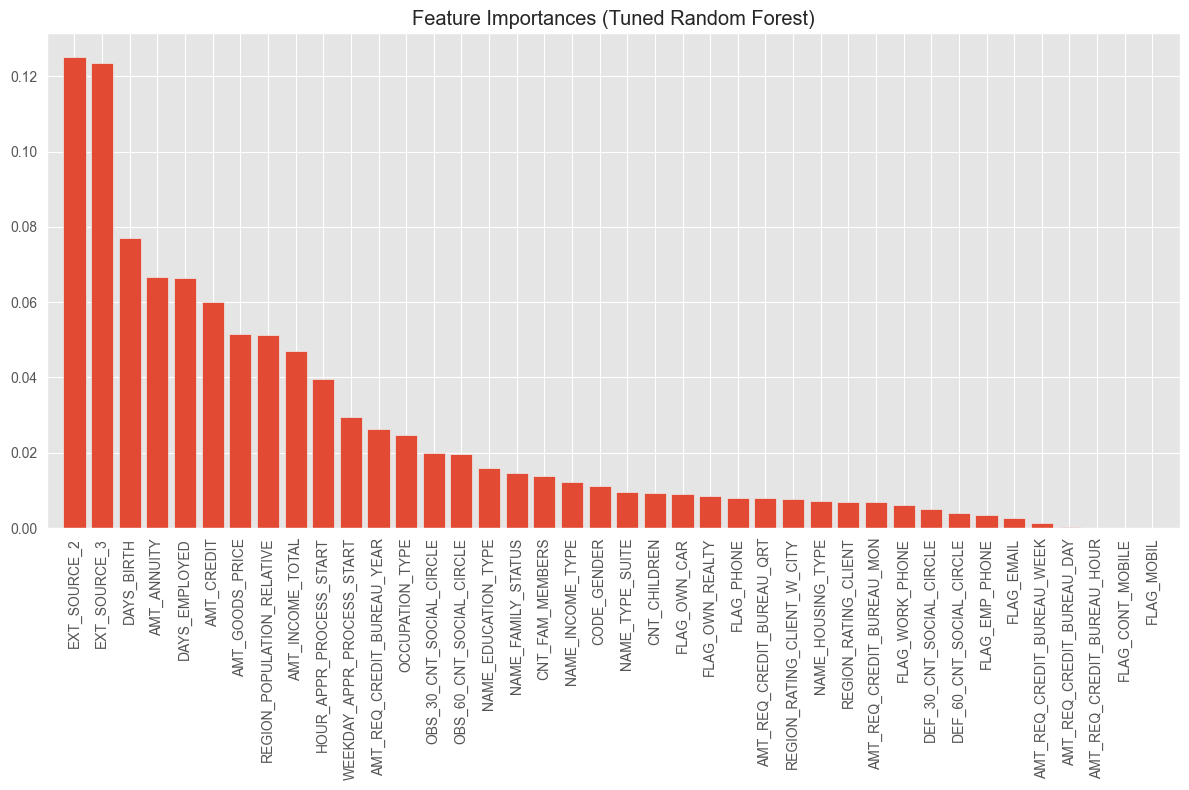

In [11]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(12, 8))
plt.title("Feature Importances (Tuned Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

## 8. Conclusion
Summarize the findings, best model, and key drivers of default risk.